# Ejercicio Data Augmentation

En este ejercicio se utilizará el dataset de manos, en el cual hay imágenes de 64x64 pixeles a color divididas en 6 clases, cada una representando un número distinto (0, 1, 2, 3, 4 o 5) indicado con los dedos de la mano.

El conjunto de entrenamiento fue modificado de forma tal que el mismo sobreentrene una red neuronal convolucional si no se aplica ningún tipo de data augmentation. Dentro de la carpeta `train/` se encuentran 6 carpetas, cada una con 30 imágenes. El conjunto de validación no fue modificado. El mismo se encuentra en la carpeta `valid/` con 20 imágenes en cada clase.

El objetivo de este ejercicio es, entonces, realizar entrenamientos de una misma arquitectura de red convolucional, utilizando data augmentation para obtener la mejor performance posible.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

### Visualización de los datos

Con la siguiente celda de código podemos visualizar una imagen de cada clase, tomada al azar, del conjunto de entrenamiento. Siempre es importante tener nocion de como lucen las imágenes de nuestro set de datos, tanto de entrenamiento como validación. Esto nos ayudará a saber que tipos de transformaciones serán más útiles cuando realicemos data augmentation.

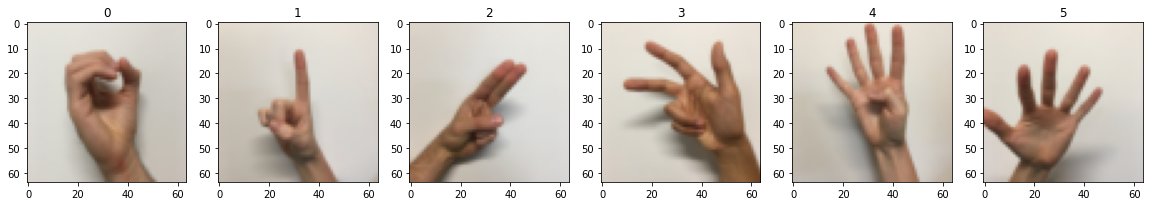

In [2]:
train_folder = './dataset_manos_modificado/train/'

fig, axs = plt.subplots(1, 6, figsize=(20, 20))

for id, class_folder in enumerate(sorted(os.listdir(train_folder))):

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image)
    axs[id].set_title(class_folder)

### Definimos nuestra función de entrenamiento

In [4]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                print("CUDA")
                train_data.to("cuda")
                train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data.to("cuda")
                valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

### Definimos nuestra arquitectura de red neuronal

En la siguiente celda se define una clase para una red neuronal convolucional con 4 capas convolucionales, cada una seguida de un max pooling. Luego del último bloque convolucional-pooling se realiza un flatten y se agregan 2 capas densas para la clasificación.

Para que esta celda funcione se debe completar el valor de `in_features` de la primera capa densa, el cual se puede calcular sabiendo el tamaño de las imágenes de entrada a la red, y cómo afecta cada capa convolucional y de pooling a las dimensión del tensor de entrada de dicha capa densa.

In [5]:
CANTIDAD_CLASES = 6
ANCHO_IMAGENES = 64
ALTO_IMAGENES = 64

In [6]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 64x64 / 2 = 32 x 32
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) #/ 2 = 16 x 16
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)  # /2 = 8 x 8
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)  # /2 = 4 x 4
        self.fc1 = torch.nn.Linear(in_features=128*4*4, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
         MaxPool2d-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Linear-9                  [-1, 512]       1,049,088
           Linear-10                    [-1, 6]           3,078
Total params: 1,149,606
Trainable params: 1,149,606
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.18
Params size (MB): 4.39
Estimat

### 1) Entrenar sin aplicar Data Augmentation

En primer lugar se define una composición de transformaciones que no realice ninguna modificación sobre las imágenes más que pasarlas a tensores, como lo pide torchvision. Luego se definen los `DataLoaders` para el entrenamiento.

In [7]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='./dataset_manos_modificado/train', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='./dataset_manos_modificado/valid', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

Realizar el entrenamiento de la red durante 30 épocas y observar el sobreentrenamiento que se genera en el modelo.

Epoch: 1/30 - Train loss 1.801014 - Train Accuracy 0.122396 - Valid Loss 1.791360 - Valid Accuracy 0.171875
Epoch: 2/30 - Train loss 1.793701 - Train Accuracy 0.164062 - Valid Loss 1.791550 - Valid Accuracy 0.166667
Epoch: 3/30 - Train loss 1.792744 - Train Accuracy 0.130208 - Valid Loss 1.791621 - Valid Accuracy 0.169271
Epoch: 4/30 - Train loss 1.792261 - Train Accuracy 0.171875 - Valid Loss 1.791537 - Valid Accuracy 0.169271
Epoch: 5/30 - Train loss 1.791549 - Train Accuracy 0.161458 - Valid Loss 1.791428 - Valid Accuracy 0.158854
Epoch: 6/30 - Train loss 1.791058 - Train Accuracy 0.143229 - Valid Loss 1.789775 - Valid Accuracy 0.166667
Epoch: 7/30 - Train loss 1.789795 - Train Accuracy 0.192708 - Valid Loss 1.787960 - Valid Accuracy 0.257812
Epoch: 8/30 - Train loss 1.786527 - Train Accuracy 0.242188 - Valid Loss 1.782425 - Valid Accuracy 0.335938
Epoch: 9/30 - Train loss 1.777181 - Train Accuracy 0.367188 - Valid Loss 1.763930 - Valid Accuracy 0.187500
Epoch: 10/30 - Train loss 1.

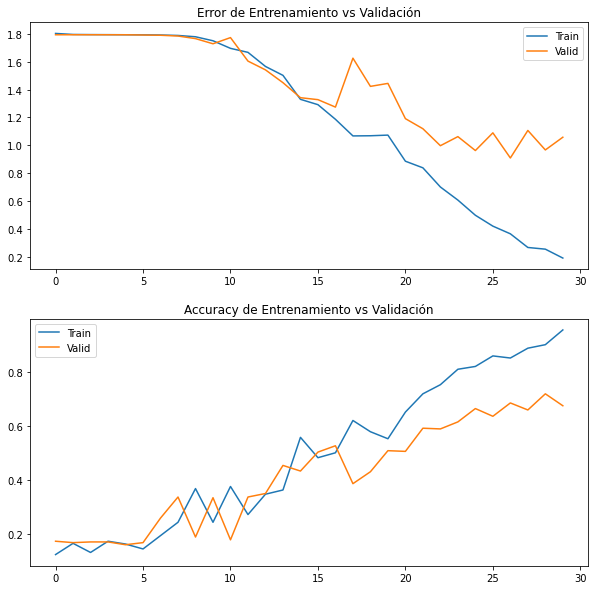

In [10]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                30,
                noaug_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

---
### 2) Entrenar aplicando Data Augmentation

A continuación se define una composición de transformaciones para aplicar data augmentation sobre el conjunto de entrenamiento.

Ejecutar la celda para entrenar durante, al menos, 100 épocas y analizar los resultados.

In [11]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(64, 64), scale=(0.2, 0.7)),
                        torchvision.transforms.RandomRotation(degrees=90),
                        torchvision.transforms.RandomPerspective(0.8),
                        torchvision.transforms.RandomGrayscale(0.5),
                        torchvision.transforms.ToTensor(),
                      ])

aug_train_set = torchvision.datasets.ImageFolder(root='./dataset_manos_modificado/train', transform=aug_data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)

Epoch: 1/100 - Train loss 1.805398 - Train Accuracy 0.153646 - Valid Loss 1.791462 - Valid Accuracy 0.166667
Epoch: 2/100 - Train loss 1.792734 - Train Accuracy 0.164062 - Valid Loss 1.791725 - Valid Accuracy 0.166667
Epoch: 3/100 - Train loss 1.792335 - Train Accuracy 0.145833 - Valid Loss 1.791698 - Valid Accuracy 0.166667
Epoch: 4/100 - Train loss 1.791959 - Train Accuracy 0.169271 - Valid Loss 1.791764 - Valid Accuracy 0.164062
Epoch: 5/100 - Train loss 1.792172 - Train Accuracy 0.158854 - Valid Loss 1.791761 - Valid Accuracy 0.166667
Epoch: 6/100 - Train loss 1.792308 - Train Accuracy 0.164062 - Valid Loss 1.791750 - Valid Accuracy 0.166667
Epoch: 7/100 - Train loss 1.791934 - Train Accuracy 0.169271 - Valid Loss 1.791920 - Valid Accuracy 0.166667
Epoch: 8/100 - Train loss 1.791892 - Train Accuracy 0.166667 - Valid Loss 1.791625 - Valid Accuracy 0.174479
Epoch: 9/100 - Train loss 1.792148 - Train Accuracy 0.158854 - Valid Loss 1.791784 - Valid Accuracy 0.161458
Epoch: 10/100 - Tra

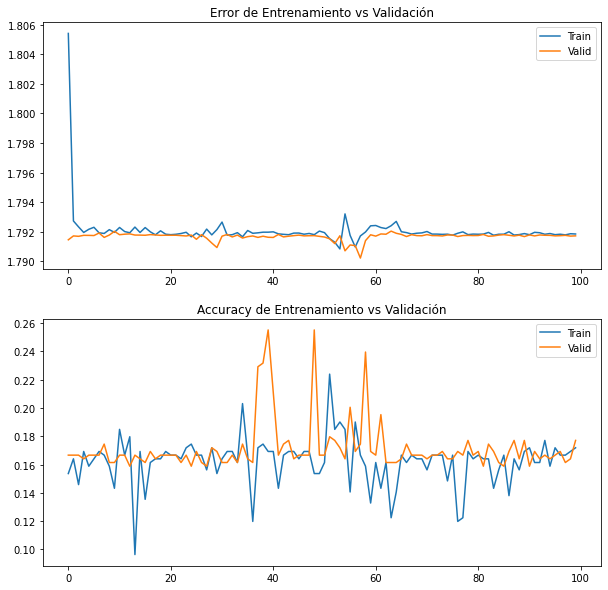

In [12]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                100,
                aug_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

###**Algunas preguntas para analizar**

1) ¿Es el resultado del entrenamiento aceptable?

2) ¿Está el Data Augmentation mejorando o empeorando el resultado?

3) Basándose en las características de las imágenes del conjunto de validación, diría que el tipo de transformaciones utilizadas es acertado? (Se puede usar la celda del principio del Colab para visualizar imágenes del conjunto de validación)

4) Basándose en los resultados del entrenamiento, diría que los parámetros de las transformaciones aplicadas tienen valores agresivos? (Se puede utilizar la celda siguiente para visualizar un conjunto de imágenes y sus versiones transformadas)

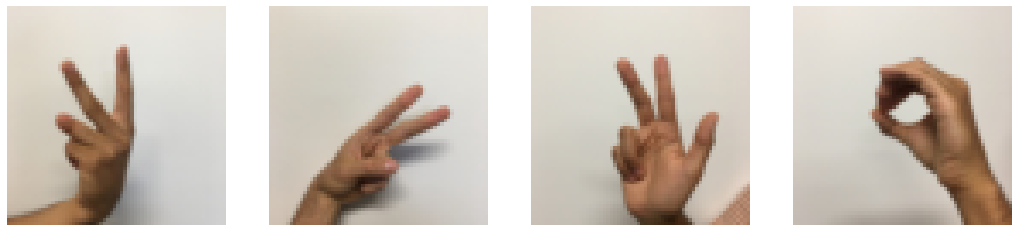

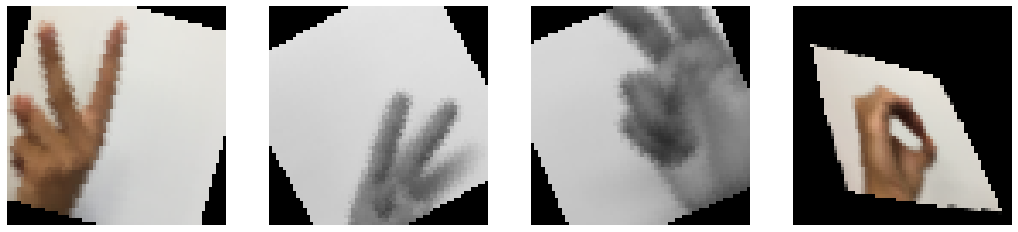

In [13]:
# Ploteo las imagenes sin augmentacion

images_ids = np.random.randint(low=0, high=len(train_set), size=4)

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for id, row in enumerate(rows):
    row.imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for id, row in enumerate(rows):
    row.imshow(aug_train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

### 3) Mejorar/corregir el Data Augmentation

En base a su criterio y a las reflexiones de las preguntas anteriores, defina una nueva composición de transformaciones que ayude a obtener buenos resultados sobre el entrenamiento. Intentar obtener métricas que superen el 90% de accuracy sin caer en sobreentrenamiento. Incrementar la cantidad de épocas de entrenamiento si es necesario.

In [14]:
new_aug_data_transforms = torchvision.transforms.Compose([
                            torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                            torchvision.transforms.RandomHorizontalFlip(0.5),
                            torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.8, 1)),
                            torchvision.transforms.RandomRotation(degrees=10, fill=210),
                            torchvision.transforms.RandomPerspective(0.1, fill=210),


                            torchvision.transforms.ToTensor(),
                        ])

new_aug_train_set = torchvision.datasets.ImageFolder(root='./dataset_manos_modificado/train', transform=new_aug_data_transforms)

new_aug_train_loader = torch.utils.data.DataLoader(new_aug_train_set, batch_size=32, shuffle=True)

Epoch: 1/100 - Train loss 1.805988 - Train Accuracy 0.122396 - Valid Loss 1.792906 - Valid Accuracy 0.143229
Epoch: 2/100 - Train loss 1.792848 - Train Accuracy 0.153646 - Valid Loss 1.791687 - Valid Accuracy 0.166667
Epoch: 3/100 - Train loss 1.792510 - Train Accuracy 0.171875 - Valid Loss 1.792076 - Valid Accuracy 0.161458
Epoch: 4/100 - Train loss 1.793020 - Train Accuracy 0.166667 - Valid Loss 1.791966 - Valid Accuracy 0.164062
Epoch: 5/100 - Train loss 1.792132 - Train Accuracy 0.161458 - Valid Loss 1.791474 - Valid Accuracy 0.166667
Epoch: 6/100 - Train loss 1.791767 - Train Accuracy 0.164062 - Valid Loss 1.791154 - Valid Accuracy 0.166667
Epoch: 7/100 - Train loss 1.791911 - Train Accuracy 0.148438 - Valid Loss 1.790504 - Valid Accuracy 0.236979
Epoch: 8/100 - Train loss 1.790098 - Train Accuracy 0.229167 - Valid Loss 1.788626 - Valid Accuracy 0.205729
Epoch: 9/100 - Train loss 1.789019 - Train Accuracy 0.239583 - Valid Loss 1.785694 - Valid Accuracy 0.289062
Epoch: 10/100 - Tra

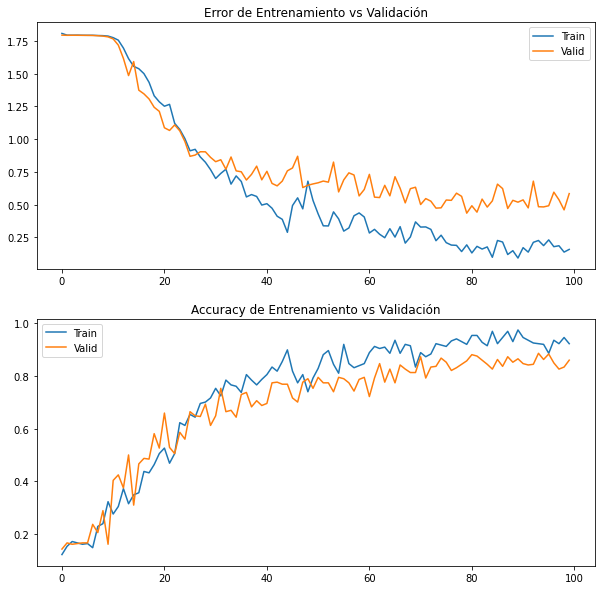

In [15]:
new_aug_conv_model = ConvModel(CANTIDAD_CLASES)
new_aug_optimizer = torch.optim.Adam(new_aug_conv_model.parameters(), lr=0.001)
new_aug_loss = torch.nn.CrossEntropyLoss()
new_aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
new_aug_data = {"train": new_aug_train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

new_aug_writer = {"train": SummaryWriter(log_dir="data_aug/new_aug_train"),
                  "valid": SummaryWriter(log_dir="data_aug/new_aug_valid")}

history = train(new_aug_conv_model,
                new_aug_optimizer,
                new_aug_loss,
                new_aug_metric,
                new_aug_data,
                100,
                new_aug_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [18]:
new_aug_conv_model.eval()


ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)

In [23]:
from PIL import Image

def preprocesar_imagen(imagen_path):
    transformacion = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    imagen = Image.open(imagen_path)
    imagen = transformacion(imagen)
    imagen = imagen.unsqueeze(0)  # Agregar dimensión batch
    return imagen

In [24]:
def predecir_imagen(imagen_path, modelo):
    
    imagen = preprocesar_imagen(imagen_path)

    with torch.no_grad():
        salida = modelo(imagen)

    _, indice_prediccion = torch.max(salida, 1)
    
    return indice_prediccion.item()

In [27]:

indice_prediccion = predecir_imagen('dataset_manos_modificado/valid/5/image_3.png', new_aug_conv_model)

print(f'La imagen pertenece a la clase: {indice_prediccion}')

La imagen pertenece a la clase: 5


### Conclusiones

- Que tipo de transformaciones son mas efectivas en este dataset?
